在前面的介绍中，我们主要探讨了机器学习的两类基本问题----回归与分类，而且介绍了很多基本的机器学习模型。但是，当我们建立好了相关模型以后我们怎么评价我们建立的模型的好坏以及优化我们建立的模型呢？那本次分享的内容就是关于机器学习模型评估与超参数调优的。本次分享的内容包括：
    用管道简化工作流使用k折交叉验证评估模型性能使用学习和验证曲线调试算法通过网格搜索进行超参数调优比较不同的性能评估指标
1. 用管道简化工作流
在很多机器学习算法中，我们可能需要做一系列的基本操作后才能进行建模，如：在建立逻辑回归之前，我们可能需要先对数据进行标准化，然后使用PCA将维，最后拟合逻辑回归模型并预测。那有没有什么办法可以同时进行这些操作，使得这些操作形成一个工作流呢？下面请看代码：                       

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
import warnings
warnings.filterwarnings("ignore")

In [5]:
# 加载数据
df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data",header=None)
# 做基本的数据预处理
from sklearn.preprocessing import LabelEncoder

X = df.iloc[:,2:].values
y = df.iloc[:,1].values
le = LabelEncoder()    #将M-B等字符串编码成计算机能识别的0-1
y = le.fit_transform(y)
le.transform(['M','B'])
# 数据切分8：2
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=1)

In [10]:
# 把所有的操作全部封在一个管道pipeline内形成一个工作流：
## 标准化+PCA+逻辑回归


### 方式1：make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr1 = make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression(random_state=1))
pipe_lr1.fit(X_train,y_train)
y_pred1 = pipe_lr1.predict(X_test)
# score = pipe_lr1.score(X_test,y_test)
print("Test Accuracy: %.3f"% pipe_lr1.score(X_test,y_test))

Test Accuracy: 0.956


In [11]:
# 把所有的操作全部封在一个管道pipeline内形成一个工作流：
## 标准化+PCA+逻辑回归


### 方式2：Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_lr2 = Pipeline([['std',StandardScaler()],['pca',PCA(n_components=2)],['lr',LogisticRegression(random_state=1)]])
pipe_lr2.fit(X_train,y_train)
y_pred2 = pipe_lr2.predict(X_test)
print("Test Accuracy: %.3f"% pipe_lr2.score(X_test,y_test))

Test Accuracy: 0.956


In [15]:
# 评估方式1：k折交叉验证

from sklearn.model_selection import cross_val_score

scores1 = cross_val_score(estimator=pipe_lr2,X = X_train,y = y_train,cv=10,n_jobs=1)
print("CV accuracy scores:%s" % scores1)
print("CV accuracy:%.3f +/-%.3f"% (np.mean(scores1),np.std(scores1)))

CV accuracy scores:[0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy:0.950 +/-0.014


使用学习和验证曲线调试算法

如果模型过于复杂，即模型有太多的自由度或者参数，就会有过拟合的风险（高方差）；而模型过于简单，则会有欠拟合的风险(高偏差)。
![jupyter](./yz.png)  

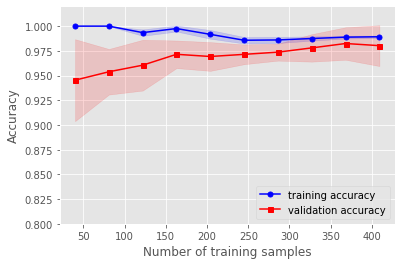

In [18]:
# 用学习曲线诊断偏差与方差
from sklearn.model_selection import learning_curve

pipe_lr3 = make_pipeline(StandardScaler(),LogisticRegression(random_state=1,penalty='l2'))
train_sizes,train_scores,test_scores = learning_curve(estimator=pipe_lr3,X=X_train,y=y_train,train_sizes=np.linspace(0.1,1,10),cv=10,n_jobs=1)
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)
plt.plot(train_sizes,train_mean,color='blue',marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean+train_std,train_mean-train_std,alpha=0.15,color='blue')
plt.plot(train_sizes,test_mean,color='red',marker='s',markersize=5,label='validation accuracy')
plt.fill_between(train_sizes,test_mean+test_std,test_mean-test_std,alpha=0.15,color='red')
plt.xlabel("Number of training samples")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.ylim([0.8,1.02])
plt.show()

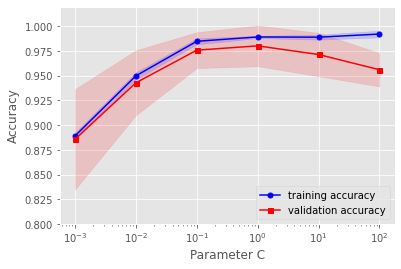

In [19]:
# 用验证曲线解决欠拟合和过拟合
from sklearn.model_selection import validation_curve

pipe_lr3 = make_pipeline(StandardScaler(),LogisticRegression(random_state=1,penalty='l2'))
param_range = [0.001,0.01,0.1,1.0,10.0,100.0]
train_scores,test_scores = validation_curve(estimator=pipe_lr3,X=X_train,y=y_train,param_name='logisticregression__C',param_range=param_range,cv=10,n_jobs=1)
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)
plt.plot(param_range,train_mean,color='blue',marker='o',markersize=5,label='training accuracy')
plt.fill_between(param_range,train_mean+train_std,train_mean-train_std,alpha=0.15,color='blue')
plt.plot(param_range,test_mean,color='red',marker='s',markersize=5,label='validation accuracy')
plt.fill_between(param_range,test_mean+test_std,test_mean-test_std,alpha=0.15,color='red')
plt.xscale('log')
plt.xlabel("Parameter C")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.ylim([0.8,1.02])
plt.show()

4. 通过网格搜索进行超参数调优

如果只有一个参数需要调整，那么用验证曲线手动调整是一个好方法，但是随着需要调整的超参数越来越多的时候，我们能不能自动去调整呢？！！！注意对比各个算法的时间复杂度

（注意参数与超参数的区别：参数可以通过优化算法进行优化，如逻辑回归的系数；超参数是不能用优化模型进行优化的，如正则话的系数。）

In [20]:
# 方式1：网格搜索GridSearchCV()
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import time

start_time = time.time()
pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1))
param_range = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
param_grid = [{'svc__C':param_range,'svc__kernel':['linear']},{'svc__C':param_range,'svc__gamma':param_range,'svc__kernel':['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring='accuracy',cv=10,n_jobs=-1)
gs = gs.fit(X_train,y_train)
end_time = time.time()
print("网格搜索经历时间：%.3f S" % float(end_time-start_time))
print(gs.best_score_)
print(gs.best_params_)

网格搜索经历时间：2.468 S
0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [21]:
# 方式2：随机网格搜索RandomizedSearchCV()
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
import time

start_time = time.time()
pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1))
param_range = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
param_grid = [{'svc__C':param_range,'svc__kernel':['linear']},{'svc__C':param_range,'svc__gamma':param_range,'svc__kernel':['rbf']}]
# param_grid = [{'svc__C':param_range,'svc__kernel':['linear','rbf'],'svc__gamma':param_range}]
gs = RandomizedSearchCV(estimator=pipe_svc, param_distributions=param_grid,scoring='accuracy',cv=10,n_jobs=-1)
gs = gs.fit(X_train,y_train)
end_time = time.time()
print("随机网格搜索经历时间：%.3f S" % float(end_time-start_time))
print(gs.best_score_)
print(gs.best_params_)

随机网格搜索经历时间：0.294 S
0.9670531400966184
{'svc__kernel': 'rbf', 'svc__gamma': 0.1, 'svc__C': 10.0}


In [22]:
# 方式3：嵌套交叉验证
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import time

start_time = time.time()
pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1))
param_range = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
param_grid = [{'svc__C':param_range,'svc__kernel':['linear']},{'svc__C':param_range,'svc__gamma':param_range,'svc__kernel':['rbf']}]
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid,scoring='accuracy',cv=2,n_jobs=-1)
scores = cross_val_score(gs,X_train,y_train,scoring='accuracy',cv=5)
end_time = time.time()
print("嵌套交叉验证：%.3f S" % float(end_time-start_time))
print('CV accuracy :%.3f +/-%.3f'%(np.mean(scores),np.std(scores)))

嵌套交叉验证：1.152 S
CV accuracy :0.974 +/-0.015


比较不同的性能评估指标
有时候，准确率不是我们唯一需要考虑的评价指标，因为有时候会存在各类预测错误的代价不一样。例如：在预测一个人的肿瘤疾病的时候，如果病人A真实得肿瘤但是我们预测他是没有肿瘤，跟A真实是健康但是预测他是肿瘤，二者付出的代价很大区别（想想为什么）。所以我们需要其他更加广泛的指标：
![jupyter](./yz1.png) 

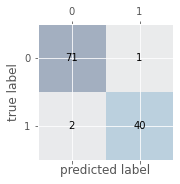

In [23]:
# 绘制混淆矩阵
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train,y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test,y_pred=y_pred)
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat, cmap=plt.cm.Blues,alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,s=confmat[i,j],va='center',ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [24]:
# 各种指标的计算
from sklearn.metrics import precision_score,recall_score,f1_score
print('Precision:%.3f'%precision_score(y_true=y_test,y_pred=y_pred))
print('recall_score:%.3f'%recall_score(y_true=y_test,y_pred=y_pred))
print('f1_score:%.3f'%f1_score(y_true=y_test,y_pred=y_pred))


Precision:0.976
recall_score:0.952
f1_score:0.964


In [25]:
# 将不同的指标与GridSearch结合
from sklearn.metrics import make_scorer,f1_score
scorer = make_scorer(f1_score,pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring=scorer,cv=10)
gs = gs.fit(X_train,y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9880771478667446
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


<Figure size 432x288 with 0 Axes>

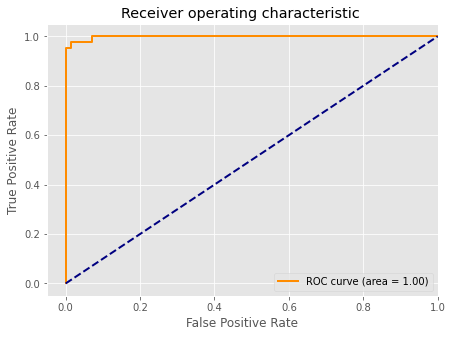

In [26]:
# 绘制ROC曲线
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import make_scorer,f1_score
scorer = make_scorer(f1_score,pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring=scorer,cv=10)
y_pred = gs.fit(X_train,y_train).decision_function(X_test)
#y_pred = gs.predict(X_test)
fpr,tpr,threshold = roc_curve(y_test, y_pred) ###计算真阳率和假阳率
roc_auc = auc(fpr,tpr) ###计算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假阳率为横坐标，真阳率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right")
plt.show()

# 3.结语
本章中，我们重点讨论了各种回归和分类算法的具体推导与简单应用，并且给出了如何使用sklearn这个强大的python工具库进行简单的机器学习模型的建模代码。本章的重点是各个基础算法的掌握，包括回归和分类(重点是分类)算法以及怎么用网格搜索以及其他搜索方式进行调参。简单模型在进行复杂项目的时候往往显得力不从心，那么在下一章中，我们将开始本次开源项目的主题----集成学习，我们着重讨论如何将本章所学的基础模型进行集成，变成功能更加强大的集成模型。
为了巩固本章的理解，在这里给个小任务，大家结合sklearn的fetch_lfw_people数据集，进行一次实战。fetch_lfw_people数据集是一个图像数据集，详细内容可以参照：
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html
案例的内容是对图像进行识别并分类。

作业地址：
https://github.com/buaamse/ml/blob/main/face%20detect_task1.ipynb